# Data preparation

## Import necessary libraries

In [1]:
# Data imports
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import ast

SEED = 42
warnings.filterwarnings("ignore")
np.random.seed(SEED)

## Load data from small matrix because big matrix breaks the ram

In [2]:
data_path = "data_final_project/KuaiRec 2.0/data/"
small_matrix = pd.read_csv(data_path + "small_matrix.csv").drop_duplicates().dropna()
user_features = pd.read_csv(data_path + "user_features.csv").drop_duplicates().dropna()
item_categories = pd.read_csv(data_path + "item_categories.csv").drop_duplicates().dropna()
caption_category = pd.read_csv(data_path + "kuairec_caption_category.csv", lineterminator='\n').drop_duplicates().dropna()

## Fix negative category id to be the 30th one

In [3]:
categories = caption_category["first_level_category_id"].unique()
categories.sort()
categories

array([-124,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   31,   32,   33,
         34,   35,   36,   37,   38,   39])

In [4]:
caption_category["first_level_category_id"] = [x if x >= 0 else 30 for x in caption_category["first_level_category_id"]]

## Data cleaning

### small_matrix / big_matrix
- time is kept for train / validation / test splitting
- watch_ratio 
    - clean unrealistic data (more than 5 rewatch) 
    - split the interation in 3 categories:
        - negative (less than 0.65)
        - neutral (between 0.65 and 1.2)
        - like (more than 1.2)
- video duration
    - remove irrelevant data (video lasts for more than 2.6 minutes)
    - split the interaction in 3 categories:
        - short video (less than 7 seconds)
        - medium video (between 7 and 16 seconds)
        - long video (longer than 16 seconds)

All user_id / video_id which are not present in the "user_features" / "caption_category" dataframe are removed since they lack information.

In [5]:
# Copy the dataframe while only keeping the relevant columns
small_matrix_cleaned = small_matrix.copy()
small_matrix_cleaned = small_matrix_cleaned[["user_id", "video_id", "watch_ratio", "time", "video_duration"]]

# Remove irrelevant / unrealistic data
small_matrix_cleaned = small_matrix_cleaned[small_matrix_cleaned["video_duration"] <= 160000]
small_matrix_cleaned = small_matrix_cleaned[small_matrix_cleaned["watch_ratio"] <= 5]

# Categorize watch_ratio
small_matrix_cleaned["like"] = np.where(small_matrix_cleaned["watch_ratio"] <= 0.65, -1,
                                np.where(small_matrix_cleaned["watch_ratio"] <= 1.2, 0, 1))

# Categorize video_length
small_matrix_cleaned["video_length"] = np.where(small_matrix_cleaned["video_duration"] <= 7000, -1,
                                np.where(small_matrix_cleaned["video_duration"] <= 16000, 0, 1))

# Drop useless columns
#small_matrix_cleaned = small_matrix_cleaned.drop(columns=["watch_ratio", "video_duration"])
small_matrix_cleaned = small_matrix_cleaned.drop(columns=["video_duration"])

# Remove users which lack information
known_user_ids = user_features["user_id"].unique()
small_matrix_cleaned = small_matrix_cleaned[small_matrix_cleaned["user_id"].isin(known_user_ids)]

# Remove videos which lack information
known_video_ids = caption_category["video_id"].unique()
small_matrix_cleaned = small_matrix_cleaned[small_matrix_cleaned["video_id"].isin(known_video_ids)]

# Check dataframe
small_matrix_cleaned.head()

,user_id,video_id,watch_ratio,time,like,video_length
0,14,148,0.722103,2020-07-05 05:27:48.378,0,-1
1,14,183,1.907377,2020-07-05 05:28:00.057,1,-1
2,14,3649,2.063311,2020-07-05 05:29:09.479,1,0
3,14,5262,0.566388,2020-07-05 05:30:43.285,-1,0
4,14,8234,0.418364,2020-07-05 05:35:43.459,-1,0


### Item_categories
- Explode video tags and create a one hot encoded vector containing the tags of each video

All video_id which are not present in the "caption_category" dataframe are removed since they lack information.

In [6]:
# Copy the dataframe and fix its format
item_categories_cleaned = item_categories.copy()
item_categories_cleaned["feat"] = item_categories_cleaned["feat"].apply(ast.literal_eval)

# Explode item tag lists
item_categories_cleaned = item_categories_cleaned.explode("feat")

# Make it a one hot encoded vector
item_categories_cleaned = pd.crosstab(item_categories_cleaned["video_id"], item_categories_cleaned["feat"])

# Set columns' names
item_categories_cleaned.columns = [f"tag_{i}" for i in range(31)]

# Fix indexes
item_categories_cleaned = item_categories_cleaned.reset_index()

# Remove videos which lack information
item_categories_cleaned = item_categories_cleaned[item_categories_cleaned["video_id"].isin(known_video_ids)]

# Check dataframe
item_categories_cleaned.head()

,video_id,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,...,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### User_features
- Keep all encoded features since all decoded features seem useless in our case
- Scale all encoded features

In [7]:
# Copy the dataframe while only keeping the relevant columns
user_features_cleaned = user_features.copy()
user_features_cleaned = user_features_cleaned[["user_id"] + [f'onehot_feat{i}' for i in range(18)]]

# Rescale data
for row in [f'onehot_feat{i}' for i in range(18)]:
    scaler = MinMaxScaler((-1, 1))
    user_features_cleaned[row] = scaler.fit_transform(user_features_cleaned[[row]])

# Check dataframe
user_features_cleaned.head()

,user_id,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat4,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,onehot_feat10,onehot_feat11,onehot_feat12,onehot_feat13,onehot_feat14,onehot_feat15,onehot_feat16,onehot_feat17
0,0,-1.0,-0.666667,0.172414,0.191410,-0.636364,-1.0,0.0,-0.739130,0.085546,1.000000,0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,-1.0,0.000000,0.724138,0.906629,-1.000000,-1.0,0.0,-0.739130,0.097345,1.000000,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2,-1.0,1.000000,-0.448276,-0.249300,-1.000000,-1.0,-1.0,-0.913043,-0.699115,-0.333333,0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3,-1.0,-0.666667,-0.448276,-0.475257,-1.000000,-1.0,-1.0,0.478261,0.480826,0.000000,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4,-1.0,-0.666667,-0.448276,-0.409897,-0.818182,-1.0,0.0,1.000000,-0.415929,0.333333,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Caption_category
- Explode first_level_category_id and create a one hot encoded vector containing the first level category id of each video

In [8]:
# Copy the dataframe while only keeping the relevant columns
caption_category_cleaned = caption_category.copy()
caption_category_cleaned = caption_category_cleaned[["video_id", "first_level_category_id"]]

# Make the first level category id a one hot encoded vector
caption_category_cleaned = pd.crosstab(caption_category_cleaned["video_id"], caption_category_cleaned["first_level_category_id"])

# Set columns' names
caption_category_cleaned.columns = [f"category_{i}" for i in range(39)]

# Fix indexes
caption_category_cleaned = caption_category_cleaned.reset_index()

# Check dataframe
caption_category_cleaned.head()

,video_id,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,...,category_29,category_30,category_31,category_32,category_33,category_34,category_35,category_36,category_37,category_38
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clustering Users

In [ ]:
user_features_for_pca = small_matrix_cleaned[["user_id"]].drop_duplicates()
user_features_for_pca = user_features_for_pca.merge(user_features_cleaned,
                                                    on="user_id",
                                                    how="left")
user_ids = user_features_for_pca["user_id"]
user_features_for_pca = user_features_for_pca.drop(columns=["user_id"])
user_features_for_pca

,watch_ratio,like,video_length,hour
0,0.939212,-0.104433,-0.056158,9.575698
1,0.841946,-0.142717,-0.054790,12.123031
2,0.930789,-0.055866,-0.052580,11.604995
3,0.898695,-0.259511,-0.051970,13.209918
4,0.798786,-0.369394,-0.048271,12.057515
...,...,...,...,...
1349,0.797598,-0.239762,-0.051189,6.072325
1350,0.944907,0.004964,-0.065520,4.716413
1351,0.770121,-0.380352,-0.049452,13.257219
1352,0.766663,-0.299741,-0.050551,14.909916


In [81]:
def perform_pca(df, n_components):
    pca = PCA(n_components=n_components, random_state=0)
    pca_result = pca.fit_transform(df)
    pca_df = pd.DataFrame(data=pca_result,
                          columns=[f'PC{i}' for i in range(n_components)])
    return pca_df, pca

In [ ]:
users_pca_df, users_pca = perform_pca(user_features_for_pca, n_components=5)
print("Explained variance ratio:", users_pca.explained_variance_ratio_)
users_pca_df.head()

Explained variance ratio: [9.94943130e-01 4.86650923e-03 1.85549700e-04]


,PC0,PC1,PC2
0,-0.823215,0.105600,0.013502
1,1.724179,0.020202,-0.044026
2,1.205944,0.142381,-0.026594
3,2.811391,-0.034599,0.070503
4,1.659250,-0.184913,0.062194


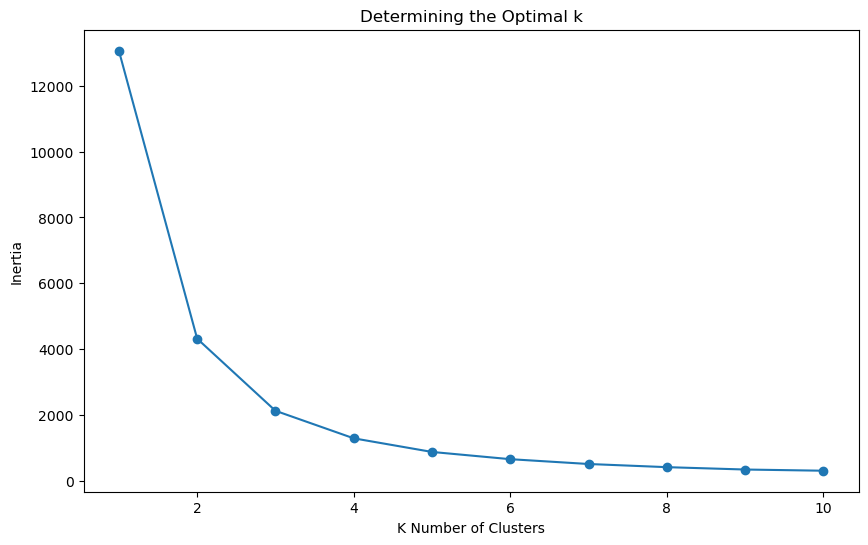

In [97]:
def plot_elbow_method(pca_df: pd.DataFrame, max_clusters: int = 10) -> int:
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=SEED)
        kmeans.fit(pca_df)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Determining the Optimal k')
    plt.show()
    return

#plot_elbow_method(users_pca_df)
plot_elbow_method(user_features_for_pca)

In [98]:
def perform_clustering(pca_df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
    clusters = kmeans.fit_predict(pca_df)
    return clusters
#user_clusters = perform_clustering(users_pca_df, n_clusters=3)
user_clusters = perform_clustering(user_features_for_pca, n_clusters=3)

In [99]:
user_cluster_mapping = pd.DataFrame({
        'user_id': user_ids,
        'user_cluster': user_clusters
    })

small_matrix_clustered = small_matrix_cleaned.merge(user_cluster_mapping, on="user_id", how="left")
small_matrix_clustered.sample(5)

,user_id,video_id,watch_ratio,time,like,video_length,user_cluster
2320698,4169,2333,1.919766,2020-07-18 00:45:55.868,1,0,0
3962438,6935,1969,0.439361,2020-07-06 20:36:58.938,-1,1,1
498007,961,3103,1.161796,2020-08-20 03:25:52.532,0,0,1
3600162,6265,9094,1.844191,2020-08-12 10:18:56.489,1,0,1
2149859,3853,5760,0.160857,2020-08-02 21:37:47.429,-1,1,1


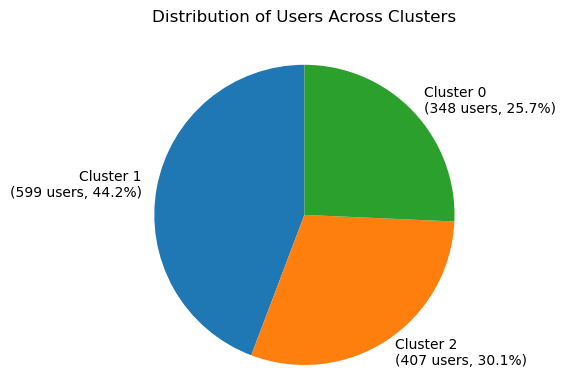

In [100]:
users = user_cluster_mapping["user_id"]
cluster_counts = user_cluster_mapping["user_cluster"].value_counts()

# Plot cluster distributions
plt.figure(figsize=(5, 4))
plt.pie(cluster_counts.values, 
        labels=[f'Cluster {i}\n({v:,} users, {(v/len(users)*100):.1f}%)' 
                for i, v in cluster_counts.items()],
        autopct='',
        startangle=90)
plt.title('Distribution of Users Across Clusters', pad=20)
plt.axis('equal')
plt.tight_layout()

## Clustering Videos

In [17]:
print(len(item_categories["video_id"].unique()))
print(len(caption_category["video_id"].unique()))

10728
9373


In [18]:
video_features_for_pca = item_categories_cleaned.copy()
video_features_for_pca = video_features_for_pca.merge(caption_category_cleaned,
                                                      on="video_id",
                                                      how="left")
video_ids = video_features_for_pca["video_id"]
video_features_for_pca = video_features_for_pca.drop(columns=["video_id"])
video_features_for_pca

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,...,category_29,category_30,category_31,category_32,category_33,category_34,category_35,category_36,category_37,category_38
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9368,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9370,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
videos_pca_df, videos_pca = perform_pca(video_features_for_pca, n_components=10)
print("Explained variance ratio:", videos_pca.explained_variance_ratio_)
videos_pca_df.head()

Explained variance ratio: [0.11104772 0.09169641 0.07948551 0.06930901 0.05602101 0.04837787
 0.04224523 0.03990359 0.03641679 0.03267327]


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-0.315369,-0.384239,-0.943416,0.767061,-0.034226,0.060371,0.012589,0.091179,-0.087976,-0.007200
1,0.026344,-0.076096,-0.075048,-0.345040,0.155334,-0.303548,1.066798,0.497921,-0.033075,-0.397976
2,-0.102016,-0.134669,-0.057072,-0.087585,-0.083001,-0.110620,-0.008322,-0.125964,0.007263,0.228986
3,-0.288013,-0.764150,0.968339,0.377918,0.112386,0.111391,0.000936,0.049487,-0.006753,-0.035364
4,-0.108296,-0.189808,-0.252832,-0.679750,0.913457,0.475893,-0.338770,-0.043609,0.023250,0.040185


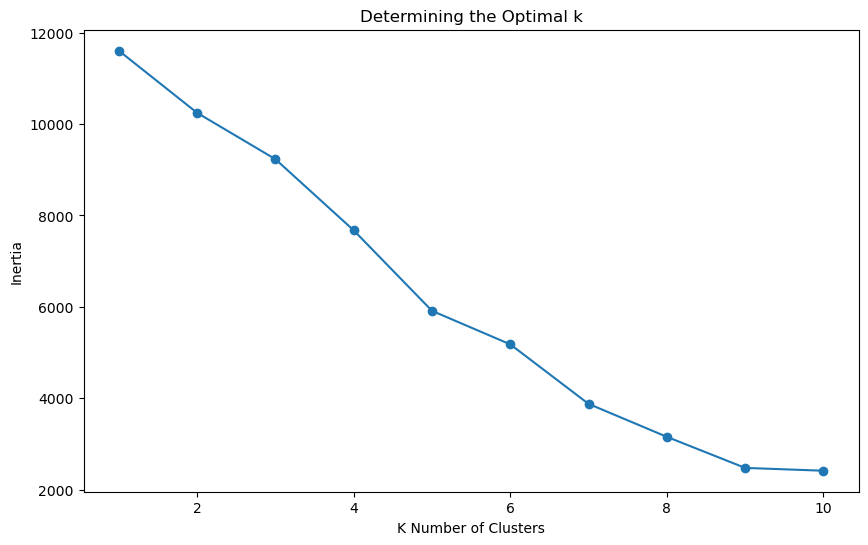

In [20]:
plot_elbow_method(videos_pca_df)

In [21]:
video_clusters = perform_clustering(videos_pca_df, n_clusters=9)

In [22]:
video_cluster_mapping = pd.DataFrame({
        'video_id': video_ids,
        'video_cluster': video_clusters
    })

small_matrix_clustered = small_matrix_clustered.merge(video_cluster_mapping, on="video_id", how="left")
small_matrix_clustered.sample(5)

,user_id,video_id,watch_ratio,time,like,video_length,user_cluster,video_cluster
2438627,4394,5635,0.620667,2020-07-27 06:59:36.612,-1,0,4,2
495319,951,1572,0.316229,2020-08-31 08:02:09.502,-1,0,3,0
2255090,4005,5383,0.100716,2020-07-31 07:57:19.214,-1,1,2,6
2207745,3935,4681,0.681732,2020-08-15 00:35:30.835,0,0,4,1
3509524,6118,4161,0.919310,2020-08-07 20:44:19.55,0,-1,1,5


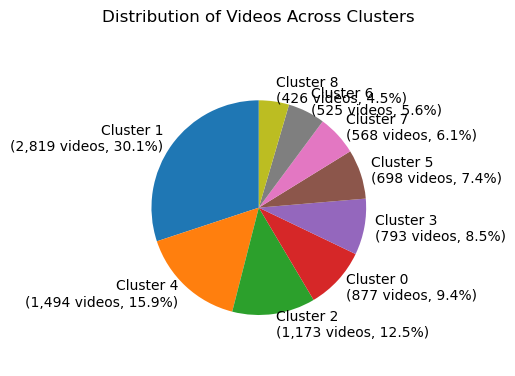

In [23]:
videos = video_cluster_mapping["video_id"]
cluster_counts = video_cluster_mapping["video_cluster"].value_counts()

# Plot cluster distributions
plt.figure(figsize=(5, 4))
plt.pie(cluster_counts.values, 
        labels=[f'Cluster {i}\n({v:,} videos, {(v/len(videos)*100):.1f}%)' 
                for i, v in cluster_counts.items()],
        autopct='',
        startangle=90)
plt.title('Distribution of Videos Across Clusters', pad=20)
plt.axis('equal')
plt.tight_layout()

In [24]:
small_matrix_clustered

,user_id,video_id,watch_ratio,time,like,video_length,user_cluster,video_cluster
0,14,148,0.722103,2020-07-05 05:27:48.378,0,-1,4,7
1,14,183,1.907377,2020-07-05 05:28:00.057,1,-1,4,2
2,14,3649,2.063311,2020-07-05 05:29:09.479,1,0,4,6
3,14,5262,0.566388,2020-07-05 05:30:43.285,-1,0,4,1
4,14,8234,0.418364,2020-07-05 05:35:43.459,-1,0,4,5
...,...,...,...,...,...,...,...,...
4083324,7162,9177,0.142857,2020-09-01 20:06:35.984,-1,1,2,1
4083325,7162,4987,1.234848,2020-09-02 14:44:51.342,1,0,2,2
4083326,7162,7988,1.024412,2020-09-03 08:45:01.474,0,1,2,1
4083327,7162,6533,0.273750,2020-09-04 22:56:32.021,-1,0,2,2
